In [1]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse, quote
import urllib.request
import os
import pypdf
from collections import deque
import io
import re
from html.parser import HTMLParser
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import uuid
from qdrant_client import models
from langchain.vectorstores.qdrant import Qdrant
from qdrant_client.models import Distance, VectorParams
from httpx import Timeout
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings

To crawl the webpage, I made use of the code mentioned in the OpenAI cookbook: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb?ref=mlq.ai

In [ ]:

# Regex pattern 
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define domain
domain = "ashoka.edu.in"
full_url = "https://ashoka.edu.in/"

# Create the class to parse the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        self.hyperlinks = []

    # Overriding the existing functions
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])


def get_hyperlinks(url):

    try:
        with urllib.request.urlopen(url) as response:
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

def pdf_to_text(pdf_content):
    # Create a PDF file object from the PDF content
    pdf_file = io.BytesIO(pdf_content)

    # Create a PDF reader object
    pdf_reader = pypdf.PdfReader(pdf_file)

    # Extract text from each page of the PDF
    text = ""
    i = 0 
    print(len(pdf_reader.pages))

    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[i].extract_text()
        i=i+1

    return text

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/" + local_domain + "/"):
        os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
        os.mkdir("processed")

    # Define the header tags to ignore while extracting text
    header_tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']

    # While the queue is not empty, continue crawling
    while queue:
        # Get the next URL from the queue
        url = queue.pop()
        print(url)  # for debugging and to see the progress

        response = requests.get(url)

        # Sanitize the URL to create a valid filename
        sanitized_url = quote(url, safe='')

        # Save text from the URL to a <url>.txt file
        with open('text/' + local_domain + '/' + sanitized_url + ".txt", "w", encoding="utf-8") as f:
            # Get the text from the URL using BeautifulSoup
            if response.headers.get('Content-Type') == ("application/pdf"):
                pdf_text = pdf_to_text(response.content)
                f.write(pdf_text)
            else:
                soup = BeautifulSoup(requests.get(url).text, "html.parser")

                # Remove header tags and anchor tags with titles from the soup object
                for tag in soup.find_all(header_tags):
                    tag.extract()
                for tag in soup.find_all('a', {'title': True}):
                    tag.extract()

                # Remove the text content within anchor tags but keep the anchor tags
                for tag in soup.find_all('a'):
                    tag.string = ''  # Set the text content within anchor tags to an empty string

                # Get the text from the soup object but preserve the text within span tags
                text = ""
                for tag in soup.find_all(string=True):
                    if tag.parent.name != 'span':
                        text += tag



                # Get the text but remove the remaining tags
                text = soup.get_text()

                # If the crawler gets to a page that requires JavaScript, it will stop the crawl
                if "You need to enable JavaScript to run this app." in text:
                    print("Unable to parse page " + url + " due to JavaScript being required")

                # Otherwise, write the text to the file in the text directory
                f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)



In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
texts = []

for file in os.listdir("text/ashoka.edu.in/"):
    with open("text/ashoka.edu.in/" + file, "r" , encoding="utf-8") as f:
        text = f.read()
        texts.append(text)

df = pd.DataFrame(texts, columns = ['text'])
df['text'] = remove_newlines(df.text)
df['id'] = [uuid.uuid4() for _ in range(len(df))]
df.to_csv('processed/scraped2.csv', escapechar="\\")
df.head()



,text,id
0,Chemistry Handbook GUIDELINES FOR STUDENTS ...,8b4ea87c-b127-4a1b-a445-c59f7d5d9dc0
1,1 POLITICAL SCIENCE HANDBOOK GUIDELINES F...,4fdd5e3e-9ca7-46b6-94f4-6bf672735324
2,Chemistry Handbook GUIDELINES FOR STUDENTS ...,505dfe41-5fc3-46d8-b2db-a2afee58778b
3,Department of BIOLOGICAL SCIENCESDepartment of...,dfdde49e-e209-44f1-b5e6-dbe70521b0d5
4,Students’ Guide Department of Computer Science...,728505e9-4065-43b5-b6b3-eb18041e5698


<Axes: >

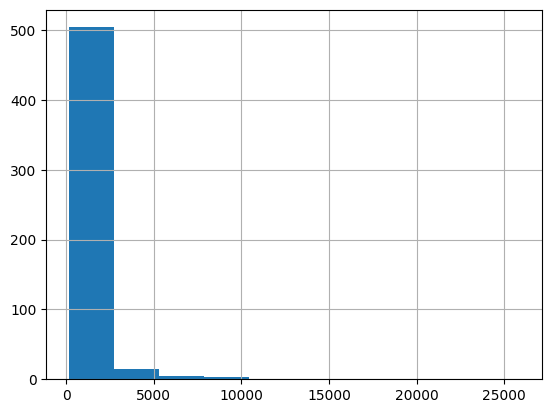

In [4]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv("processed/scraped2.csv", index_col= 0)
df.columns = ['text', 'id']
df = df[pd.notna(df['text'])]
df['no_tokens'] = df.text.apply(lambda x : len(tokenizer.encode(x)))
df['no_tokens'].hist()

In [37]:
#Just to save the emebddings on to the disk
import google.generativeai as genai
import pandas as pd
import numpy as np
import uuid

def embed_texts_in_batches(texts, batch_size=5, model="models/embedding-001"):
    embeddings_list = []
    texts = [str(text) for text in texts if not isinstance(text, float) or not np.isnan(text)]
    # Split texts into batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        embeddings_batch = embed_batch(batch_texts, model=model)
        embeddings_list.extend(embeddings_batch)

    return pd.DataFrame({"text": texts, "embedding": embeddings_list, "id" :[uuid.uuid4() for _ in range(len(texts))]})

def embed_batch(texts, model):
    return genai.embed_content(
            model=model,
            content=texts,
            task_type="retrieval_document"
        )['embedding']
  

texts = df['text'].tolist()
embeddings_df = embed_texts_in_batches(texts, batch_size=5)
embeddings_df.to_csv('processed/final.csv', index=False)  
print(embeddings_df)

                                                  text  \
0    Chemistry Handbook    GUIDELINES FOR STUDENTS ...   
1     The core (theory) courses are:  • Energetics ...   
2    For 1000/2000 level courses like ‘Chemistry fo...   
3    These are all 3000 level courses  • Basic Inor...   
4     2. Can laboratory courses be counted as an el...   
..                                                 ...   
903  For completing a major in Sociology and Anthro...   
904  For completing a minor, a student has to take ...   
905     Courses to be offered in Monsoon Semester 2...   
906  These will        be intensive weekly sessions...   
907   Q: Is it mandatory for majors to finish 1101 ...   

                                             embedding  \
0    [0.041855942, -0.019184085, -0.04255649, -0.04...   
1    [0.04032769, -0.00032470832, -0.02137377, -0.0...   
2    [0.032604985, -0.039614826, -0.05501883, -0.03...   
3    [0.03609055, -0.02177331, -0.046362255, -0.044...   
4    [0.07617

In [ ]:
#to upsert directly to the disk

import ast
from itertools import islice

embeddings_df = pd.read_csv('processed/final.csv')
embeddings_df['embedding'] = embeddings_df['embedding'].apply(ast.literal_eval)
embeddings_df.to_csv('processed/final.csv')



def batched(iterable, n):
    iterator = iter(iterable)
    while batch := list(islice(iterator, n)):
        yield batch

batch_size = 100

for batch in batched(embeddings_df.to_dict('records'), batch_size):
    ids = [point["id"] for point in batch]
    vectors = [point["embedding"] for point in batch]
    payloads = [{"text": point["text"]} for point in batch]

    client.upsert(
        collection_name="University_assistant",
        points=models.Batch(
            ids=ids,
            vectors=vectors,
            payloads=payloads,
        ),
    )

In [ ]:
from itertools import islice

def batched(iterable, n):
    iterator = iter(iterable)
    while batch := list(islice(iterator, n)):
        yield batch

batch_size = 100

for batch in batched(embeddings_df.to_dict('records'), batch_size):
    ids = [point["id"] for point in batch]
    vectors = [point["embedding"] for point in batch]
    payloads = [{"text": point["text"]} for point in batch]

    client.upsert(
        collection_name="University_assistant",
        points=models.Batch(
            ids=ids,
            vectors=vectors,
            payloads=payloads,
        ),
    )

In [57]:
from qdrant_client import QdrantClient
client = QdrantClient(
    url=os.getenv('QDRANT_HOST'),
    api_key=os.getenv('QDRANT_API_KEY'),
)

client.recreate_collection(
    collection_name= 'University_assistant', vectors_config= VectorParams(size = 768, distance= Distance.COSINE)
)

embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_document')
vector_store = Qdrant(client=client, collection_name='University_assistant',embeddings=embeddings,)
vector_store.add_texts(df['text'])

C:\Users\NITRO\AppData\Local\Temp\ipykernel_12336\2877362449.py:7: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


['1a0bc22c1d4f4129bca9acf9a89a5ceb',
 '402f7977971b4b8fae1a0eea164e015d',
 'be643c918dd649548520aba21fbbfe9d',
 'd5fe8c778b074d6b852e05af44f23d49',
 '588639adf6a7491fab0338fe8da6a5cd',
 '7e17f34558dc4074b2bdc406f0f4b0a3',
 '526a066bec8d48ceb09a294ff2779c5e',
 'ee71fe23fdf44472993516c7370aa1c3',
 'b3d0b5082305421ea070c4b3b17c8b37',
 'fcd147565e944268a31347a30af5a07a',
 '1c99a3f8eb08494bb82e086e11188942',
 'b982b1272eec43299f578660d190aa3a',
 '79d0cf8676c54fc5bb2523bb5e78c456',
 '12ec223a130c4a1196669e705e13583a',
 'd3280bfd58904d72824b2ea62dfc0581',
 '808218ed53f34d26ae19a4de12f3ff59',
 'f2d2959e004a4fcda97e4c0ce44ec543',
 'f2dde729da934b8abab1ce92e7b8353f',
 '884e97eeec2446648bbbfd29a3b8f93a',
 'fb540f1227574603ba1e75fbceff5ac3',
 'd5e01f1ecc814ed7a8aa44286dbbc051',
 '143284c6f3a3410d8c3f4276cb7551f1',
 '32dd41935a5042ecbebb117609b7d1cf',
 'e767aca03bb44f469ae2ace368401d35',
 '9d8e93c0d21c46a3b26c911331d9a00e',
 '1b621def829543e4a0636f289fd8baf6',
 '6f910cdf891048a8b3e90a02b3ea186b',
 

In [60]:
doc_store = Qdrant(client=client, 
                   collection_name='University_assistant',
                   embeddings= embeddings)
#Examples
embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001', google_api_key= os.getenv('GOOGLE_API_KEY'), task_type='retrieval_query')
hits = client.search(
	collection_name="University_assistant",
	query_vector=embeddings.embed_query("Physics department handbook"),
	limit=20
)
for hit in hits:
	print(hit.payload, "score:", hit.score)

{'metadata': None, 'page_content': ' PHYSICS HANDBOOK 2020 -21   DEPARTMENT OF PHYSICS ASHOKA UNIVERSITY            1 Contents 1. Introduction                      2 2. Physics Major - Typical Trajectory    3 3. Physics Minor and Concentration          4 4. General Information on the Phy sics courses        5 5. List of Physics Courses                  ➢ Core/ Compulsory Courses   5 ➢ Elective Physics Courses   9 ➢ Cross -listed Electives   9 6. Physics ASP                       10 7. TF/TA -ship Policy                   12 8. ISM                          12 9. Faculty                         13 10. FAQs      20         2 Introduction Physics is a doorway to some of the most beautiful and profound phenomena in the universe like black holes, supernovae, Bose -Einstein condensates, superconductors. It is, simultaneously, a driver of lifestyle -changing technology, e.g., engines, electricity, and transistors; and a powerful way of perceiving and analyzing problems that can be applied in v

In [63]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAI

retriever = doc_store.as_retriever(search_kwargs = {"k": 5})
llm = GoogleGenerativeAI(model='gemini-pro', google_api_key=os.getenv('GOOGLE_API_KEY'))

template = """
You are a helpful AI assistant.
Answer based on the context provided.You need not look for the exact similarity from the context.
context: {context}
input: {input}
answer:
"""
prompt = PromptTemplate.from_template(template)
combine_docs_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

response = retrieval_chain.invoke({"input": "What is the recommended trajectory of a mathematics science major? and answer me in details"})
print(response["answer"])


**Suggested Course Progression**

**A student majoring in math should take Calculus in the first semester.** This course is a prerequisite to further mathematics courses. Students thinking of studying mathematics should take this course as early as possible, possibly the first or the second semester. A student who wants to decide later can take the Math FC in the first semester.

If a student is interested in the mathematics major, the student should follow the suggested course sequence for math majors starting from the second semester. The following tables show the intended course sequence for math majors (for students who joined in 2019 or later).

**For Students taking Calculus in the First Semester (2019 or later)**

| Semester 1 | Semester 2 | Semester 3 | Semester 4 | Semester 5 | Semester 6 |
|---|---|---|---|---|---|
| Calculus *# | Linear Algebra *# | Algebra I *# | Algebra II | Complex Analysis | Differential Geometry |
|  | | | | |  Multivar. Calculus *# |
|  |  |  |  |  |  